# Real Time Style Transfer with TensorFlow and Keras
<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/abrampers/real-time-style-transfer-tensorflow/blob/master/Real%20Time%20Style%20Transfer%20-%20TensorFlow.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/abrampers/real-time-style-transfer-tensorflow/blob/master/Real%20Time%20Style%20Transfer%20-%20TensorFlow.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>

In this notebook, we'll implement a network that performs __neural style transfer__ based on paper by [Justin Johnson, et al](https://cs.stanford.edu/people/jcjohns/eccv16/).
>[Justin Johnson's paper](https://cs.stanford.edu/people/jcjohns/eccv16/) states that using this method is giving similar qualitative results but is three orders of magnitude faster than optimization technique outlined in [Leon A. Gatys' paper, A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576).

## Overview
Neural style transfer is an optimization technique used to take three images, a __content__ image, a __style reference__ image (such as an artwork by a famous painter), and the input image you want to style -- and blend them together such that the input image is transformed to look like the content image, but “painted” in the style of the style image.

In this paper, style transfer is done by training a deep convolutional neural network using a pretrained deep convolutional neural network. In this case, we're using [VGG16](https://arxiv.org/abs/1409.1556) pretrained on imagenet dataset.

# TODO: masukin gambar arsitektur networknya

## TODOS:
1. Create keras.Layers class instead of functions
2. Search for style images

### List of style images
1. starry night
2. hockney
3. monet
4. rain princess
5. the scream
6. udnie


In [8]:
# import resources
import tensorflow as tf

from PIL import Image

import matplotlib.pyplot as plt
import os
import numpy as np

tf.enable_eager_execution()

## Load in the Content and Style images
Here, we create function to load image and do VGG16 standard preprocessing using `tf.keras.applications.vgg16.preprocess_input`.

In [9]:
def load_image(image_path, target_size=None):
    """ Load image from path and do VGG16 standard preprocessing with tf mode.
        Returns a tensor representation of the image.
    """
    image = tf.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    if target_size is not None:
        image = tf.image.resize_images(image, target_size)
    image_shape = tf.shape(image)
    image = tf.reshape(image, [1, image_shape[0], image_shape[1], image_shape[2]])
    return tf.to_float(image)

We're going to implement the function to load image from the MS COCO dataset given the image path.

In [10]:
def load_train_image(image_path):
    """ Mapping function to load train image from path
    """
    img = tf.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize_images(img, (480, 640))
    image_shape = tf.shape(img)
    img = tf.reshape(img, [image_shape[0], image_shape[1], image_shape[2]])
    return tf.to_float(img)

Here's a few helper to show and save the image from a `tf.Tensor`.

In [11]:
def imshow(image, title=None):
    """ Showing image tensor
    """
    image = image.numpy()
    # Remove the batch dimension
    image = np.squeeze(image)
    if title is not None:
        plt.title(title)
    plt.imshow(image/255.)
    plt.show()

In [12]:
def save_image(image, image_path):
    """ Save image from tensor
    """
    image = tf.cast(image, tf.uint8)
    image = tf.squeeze(image, axis=0)
    image = tf.image.encode_jpeg(image)
    tf.io.write_file(image_path, image)

Next, we're loading the content image by the name of the file and show the image.

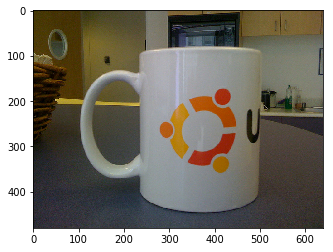

In [13]:
content_image = load_image("image/content/mug.jpg")
imshow(content_image)
content_shape = tf.shape(content_image)
_, img_height, img_width, _ = content_shape

We're going to load and show the style image and force the style image to match the size of the image.

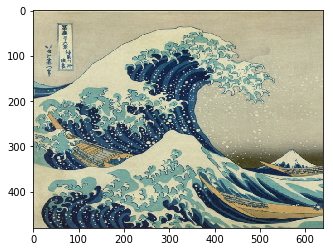

In [14]:
style_image = load_image("image/style/wave_crop.jpg", target_size=(img_height, img_width))
imshow(style_image)

## Load in the Training images
Here, we load [Microsoft's COCO dataset](https://arxiv.org/pdf/1405.0312.pdf) for training the network.

In [15]:
name_of_zip = 'train2014.zip'
name_of_folder = 'train2014'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_folder):
    image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    mscoco_path = os.path.dirname(image_zip)+'/train2014/'
else:
    mscoco_path = os.path.abspath('.')+'/train2014/'

In [16]:
train_batchsize = 4
mscoco_path

'/Users/abrampers/Documents/ML/real-time-style-transfer-tensorflow/train2014/'

In [17]:
# Get filenames of the training images
mscoco_filenames = tf.constant(mscoco_path) + os.listdir('train2014')

In [18]:
# Create a `tf.data.Dataset` filenames
train_dataset = tf.data.Dataset.from_tensor_slices(mscoco_filenames)
# Load all the data from filenames
train_dataset = train_dataset.map(load_train_image)
# Create dataset with train_batchsize
train_dataset = train_dataset.batch(train_batchsize)

Make sure that the data is loaded

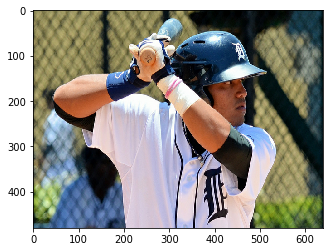

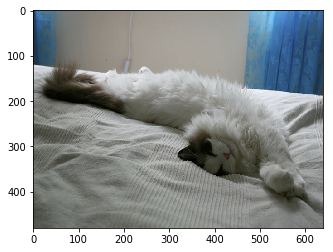

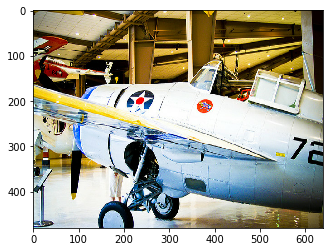

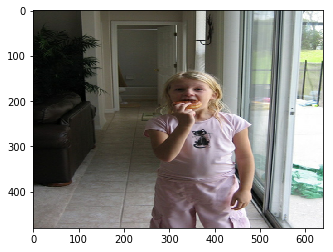

In [19]:
# Test and show the first batch of the dataset
batch_image = next(iter(train_dataset))
for image in batch_image:
    imshow(image)

## Define the network with TensorFlow
Below is where we'll define the network as in the paper of [Justin Johnson, et al](https://cs.stanford.edu/people/jcjohns/eccv16/).

<img src="image/assets/model_architecture.png" width=800px>

Next, we'll use TensorFlow to define the architecture of the network. We start by defining the layers and operations we want. Then, define a method for the forward pass.

### Define the layers
Before defining the model, we define the layers as the building blocks of the model.

In [146]:
class InputNormalize(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(InputNormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, x, mask=None):
        return (x / 127.5) - 1
    
class ReflectionPadding(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ReflectionPadding, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, inputs, mask=None):
        return tf.pad(inputs, [[0, 0], [40, 40], [40, 40], [0, 0]], "REFLECT")
    
class ConvBatchNorm(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size, strides, padding="same", relu=True, **kwargs):
        super(ConvBatchNorm, self).__init__(**kwargs)
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.relu = relu
        
        # Layers
        self.conv2d = tf.keras.layers.Conv2D(filters=self.n_channels, 
                                       kernel_size=self.kernel_size, 
                                       strides=self.strides, 
                                       padding=self.padding)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation("relu")

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, inputs, mask=None):
        conv = self.conv2d(inputs)
        bn = self.batch_norm(conv)
        if self.relu:
            return self.activation(bn)
        else:
            return bn
        
class ConvTransposeBatchNorm(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size, strides, padding="same", relu=True, **kwargs):
        super(ConvTransposeBatchNorm, self).__init__(**kwargs)
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.relu = relu
        
        # Layers
        self.conv2dtranspose = tf.keras.layers.Conv2DTranspose(filters=self.n_channels, 
                                                kernel_size=self.kernel_size, 
                                                strides=self.strides, 
                                                padding=self.padding)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation("relu")

    def build(self, input_shape):
        pass

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, inputs, mask=None):
        conv = self.conv2dtranspose(inputs)
        bn = self.batch_norm(conv)
        if self.relu:
            return self.activation(bn)
        else:
            return bn
        
class DenormalizeOutput(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DenormalizeOutput, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, inputs, mask=None):
        return (inputs + 1.) * 127.5
    

def reflection_padding():
    """Reflection padding layer for output size to match the input size"""
    def f(inputs):
        return tf.pad(inputs, [[0, 0], [40, 40], [40, 40], [0, 0]], "REFLECT")
    return f

def conv_layer(n_channels, kernel_size, strides, padding="same", relu=True):
    """Convolutional layer wrapper"""
    def f(inputs):
        conv = tf.layers.Conv2D(filters=n_channels, 
                                      kernel_size=kernel_size, 
                                      strides=strides, 
                                      padding=padding,
                               trainable=True)(inputs)
        bn = tf.layers.BatchNormalization()(conv)
        if relu:
            return tf.keras.layers.Activation("relu")(bn)
        else:
            return bn
        
    return f

def conv_transpose_layer(n_channels, kernel_size, strides, padding="same", relu=True):
    """Convolutional transpose layer to upsample the image"""
    def f(inputs):
        conv = tf.layers.Conv2DTranspose(n_channels, 
                                               kernel_size=kernel_size, 
                                               strides=strides, 
                                               padding=padding)(inputs)
        bn = tf.layers.BatchNormalization()(conv)
        if relu:
            return tf.keras.layers.Activation("relu")(bn)
        else:
            return bn
        
    return f

### Residual block
In this network, we'll use residual blocks as in the paper by [Deep residual learning for image recognition by He, et al.]()

However the residual blocks we are going to implement will follow the architecture outlined in [Gross, et al.]()

<img src="image/assets/residual_block_architecture.png" width="150px">

In [147]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, n_channels, kernel_size=3, strides=1, padding='valid', **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, inputs, mask=None):
        _, h, w, _ = inputs.get_shape().as_list()
        
        # Downsample the residual to match output of the convolution
        residual = tf.image.resize_image_with_crop_or_pad(inputs, h - 4, w - 4)
        
        conv_1 = tf.keras.layers.Conv2D(filters=self.n_channels, 
                                      kernel_size=self.kernel_size, 
                                      strides=self.strides, 
                                      padding=self.padding)(inputs)
        bn_1 = tf.keras.layers.BatchNormalization()(conv_1)
        relu_1 = tf.keras.layers.Activation("relu")(bn_1)
        conv_2 = tf.keras.layers.Conv2D(filters=self.n_channels, 
                                      kernel_size=self.kernel_size, 
                                      strides=self.strides, 
                                      padding=self.padding)(relu_1)
        bn_2 = tf.keras.layers.BatchNormalization()(conv_2)
        return tf.keras.layers.add([bn_2, residual])
    
class ResizeImage(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ResizeImage, self).__init__(**kwargs)


    def build(self, input_shape):
        pass

    def compute_output_shape(self,input_shape):
        return input_shape

    def call(self, inputs, mask=None):
        _, h, w, _ = inputs.get_shape().as_list()
        residual = tf.image.resize_image_with_crop_or_pad(inputs, h - 4, w - 4)
        return residual
        
def residual_block(n_channels, kernel_size=3, strides=1, padding='valid'):
    """Residual Block. Center cropped the input to match output size"""
    def f(inputs):
        _, h, w, _ = inputs.get_shape().as_list()
        
        # Downsample the residual to match output of the convolution
        residual = tf.image.resize_image_with_crop_or_pad(inputs, h - 4, w - 4)
        
        conv_1 = tf.layers.Conv2D(filters=n_channels, 
                                        kernel_size=kernel_size, 
                                        strides=strides, 
                                        padding=padding)(inputs)
        bn_1 = tf.layers.BatchNormalization()(conv_1)
        relu_1 = tf.keras.layers.Activation("relu")(bn_1)
        conv_2 = tf.layers.Conv2D(filters=n_channels, 
                                        kernel_size=kernel_size, 
                                        strides=strides, 
                                        padding=padding)(relu_1)
        bn_2 = tf.layers.BatchNormalization()(conv_2)
        return tf.keras.layers.add([bn_2, residual])

    return f

In [148]:
model = tf.keras.Sequential([
    InputNormalize(),
    ReflectionPadding(),
    # 1
    tf.keras.layers.Conv2D(32, 9, 1, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    # 2
    tf.keras.layers.Conv2D(64, 3, 2, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    # 3
    tf.keras.layers.Conv2D(128, 3, 2, padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    # 4
    ResidualBlock(128, 3, 1),
    
    
#     ConvBatchNorm(32, 9, 1),
#     ConvBatchNorm(64, 3, 2),
#     ConvBatchNorm(128, 3, 2),
#     ResidualBlock(128, 3, 1),
#     ResidualBlock(128, 3, 1),
#     ResidualBlock(128, 3, 1),
#     ResidualBlock(128, 3, 1),
#     ResidualBlock(128, 3, 1),
#     ConvTransposeBatchNorm(64, 3, 2),
#     ConvTransposeBatchNorm(32, 3, 2),
#     ConvBatchNorm(3, 9, 1, relu=False), 
    tf.keras.layers.Activation("tanh"),
    DenormalizeOutput()
])

In [149]:
model = tf.keras.Sequential([
    InputNormalize(),
    ReflectionPadding(),
    ConvBatchNorm(32, 9, 1),
    ConvBatchNorm(64, 3, 2),
    ConvBatchNorm(128, 3, 2),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ConvTransposeBatchNorm(64, 3, 2),
    ConvTransposeBatchNorm(32, 3, 2),
    ConvBatchNorm(3, 9, 1, relu=False), 
    tf.keras.layers.Activation("tanh"),
    DenormalizeOutput()
])

In [150]:
model(content_image, training=True)

<tf.Tensor: id=30498, shape=(1, 480, 640, 3), dtype=float32, numpy=
array([[[[133.03806 , 124.88829 , 135.7368  ],
         [139.9346  , 132.61125 , 120.6546  ],
         [144.28418 , 127.177956, 147.83592 ],
         ...,
         [127.08049 , 125.99546 , 110.702835],
         [146.29158 , 123.06955 , 140.88554 ],
         [122.70903 , 133.80519 , 125.2048  ]],

        [[134.97191 , 138.5821  , 130.93282 ],
         [135.90797 , 142.75801 , 125.05299 ],
         [147.63528 , 139.74202 , 114.55171 ],
         ...,
         [150.26358 , 136.1008  , 112.8774  ],
         [143.99594 , 122.00633 , 120.61519 ],
         [117.732506, 119.539024, 122.7671  ]],

        [[127.329315, 127.12735 , 136.6452  ],
         [138.89297 , 139.69267 , 141.63084 ],
         [140.12881 , 130.0414  , 129.9124  ],
         ...,
         [132.05615 , 136.81299 , 145.64346 ],
         [149.6502  , 130.22993 , 129.09827 ],
         [142.95924 , 124.96746 , 119.98201 ]],

        ...,

        [[119.38293 , 13

In [151]:
model.variables

[]

### Define the Image Transform Network
We've created all the necessary layers, now it's time to implement the actual image transformation layer!

<img src="image/assets/model_specification.png" width="300px">

Here's the exact model architecture based on [Justin Johnson's supplementary material](https://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf) that we're going to implement.

In [95]:
class StyleTransferModel(tf.keras.Model):
    """Style Transfer Model class"""
    def __init__(self):
        super(StyleTransferModel, self).__init__(name='style_transfer_model')
        
        # Layers
        self.pad = reflection_padding()
        self.conv_1 = conv_layer(32, 9, 1)
        self.conv_2 = conv_layer(64, 3, 2)
        self.conv_3 = conv_layer(128, 3, 2)
        self.res_1 = residual_block(128, 3, 1)
        self.res_2 = residual_block(128, 3, 1)
        self.res_3 = residual_block(128, 3, 1)
        self.res_4 = residual_block(128, 3, 1)
        self.res_5 = residual_block(128, 3, 1)
        self.conv_4 = conv_transpose_layer(64, 3, 2)
        self.conv_5 = conv_transpose_layer(32, 3, 2)
        self.conv_6 = conv_layer(3, 9, 1, relu=False)


        
    def call(self, inputs):
        # (width x height x channels)
        # 256 x 256 x 3
        inputs = (inputs / 127.5) - 1
        # 336 x 336 x 3
        padded = self.pad(inputs)
        # 336 x 336 x 32
        conv_1_out = self.conv_1(padded)
        # 168 x 64 x 64
        conv_2_out = self.conv_2(conv_1_out)
        # 84 x 84 x 128
        conv_3_out = self.conv_3(conv_2_out)
        # 80 x 80 x 128
        res_1_out = self.res_1(conv_3_out)
        # 76 x 76 x 128
        res_2_out = self.res_2(res_1_out)
        # 72 x 72 x 128
        res_3_out = self.res_3(res_2_out)
        # 68 x 68 x 128
        res_4_out = self.res_4(res_3_out)
        # 64 x 64 x 128
        res_5_out = self.res_5(res_4_out)
        # 128 x 128 x 64
        conv_4_out = self.conv_4(res_5_out)
        # 256 x 256 x 32
        conv_5_out = self.conv_5(conv_4_out)
        # 256 x 256 x 3
        conv_6_out = self.conv_6(conv_5_out)
        tanh_out = tf.tanh(conv_6_out)
        out = (tanh_out + 1) * 255. / 2
        return out
    
    def preprocess_input(x):
        """ Denormalizes input
        """
        return (x / 127.5) - 1

In [96]:
net = StyleTransferModel()

In [97]:
net(content_image)

<tf.Tensor: id=17193, shape=(1, 480, 640, 3), dtype=float32, numpy=
array([[[[120.02716 , 131.71089 , 132.0567  ],
         [128.55478 , 130.62442 , 125.61308 ],
         [116.50741 , 128.83493 , 130.35709 ],
         ...,
         [132.6098  , 126.764   , 135.38719 ],
         [130.8082  , 135.89186 , 139.64589 ],
         [139.59557 , 131.08374 , 129.09412 ]],

        [[123.81714 , 138.66681 , 118.35196 ],
         [114.89769 , 122.97354 , 126.12313 ],
         [116.26442 , 141.27402 , 110.12515 ],
         ...,
         [131.66818 , 116.55099 , 118.88437 ],
         [131.69682 , 126.32604 , 115.09115 ],
         [127.52327 , 129.96152 , 134.67857 ]],

        [[130.28871 , 115.910225, 123.32397 ],
         [135.66873 , 131.79005 , 133.82303 ],
         [127.665764, 123.857155, 119.57523 ],
         ...,
         [134.52562 , 128.07178 , 137.29213 ],
         [132.00854 , 114.418   , 120.85812 ],
         [144.2917  , 126.72993 , 131.87785 ]],

        ...,

        [[129.08977 , 13

Try forward pass the content_image

In [27]:
def get_style_features(model, image):
    """ Run an image forward through a model and get the features for 
        a set of style layers.
        Returns a dictionary of the layer name and the activations.
    """
    style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for layer in model.layers:
        x = layer(x)
        if layer.name in style_layers:
            features[layer.name] = x
            if layer.name == 'block4_conv3':
                break
            
    return features

def get_content_feature(model, image):
    """ Run an image forward through a model and get the features for 
        a set of conent layers.
        Returns the activation of the content layer
    """
    style_layers = ['block3_conv3']
    
    x = image
    # model._modules is a dictionary holding each module in the model
    for layer in model.layers:
        x = layer(x)
        if layer.name in style_layers:
            features = x
            break
            
    return features

In [28]:
def gram_matrix(x):
    """ Compute gram matrix of a 3 dimensional convolution
    """
    b, h, w, c = tf.shape(x)
    x = tf.reshape(x, [b, c, -1])
    size = tf.to_float(c * h * w)
    return  tf.matmul(x, tf.transpose(x, perm=[0, 2, 1])) / size

In [29]:
def loss(y, content_image, style_image, content_weight, style_weight):
    """ Compute loss of output with respect to content and style image
    """
    # Pretrained VGG16 on imagenet
    vgg = tf.keras.applications.vgg16.VGG16()
    
    # Freeze all VGG layers
    for layer in vgg.layers[-19:]:
        layer.trainable = False
    
    # Style features of output
    output_style_features = get_style_features(vgg, y)
    # Content features of output
    output_content_feature = get_content_feature(vgg, y)
    
    # Style features of style image
    style_features = get_style_features(vgg, style_image)
    # Content features of content image
    content_feature = get_content_feature(vgg, content_image)
    
    # Compute content loss
    # (output - content )/(Cj * Hj * Wj)
    content_loss = content_weight * tf.reduce_mean(tf.math.square(output_content_feature - content_feature))
    
    # Compute style loss
    # Gram matrix of output features
    output_grams = [gram_matrix(x) for _, x in output_style_features.items()]
                                                  
    # Gram matrix of style features
    style_grams = [gram_matrix(x) for _, x in style_features.items()]
    
    style_losses = [tf.square(tf.norm(output_gram - style_gram)) for output_gram, style_gram in zip(output_grams, style_grams)]
    style_loss = style_weight * tf.reduce_sum(tf.convert_to_tensor(style_losses)) / 4.
                                                  
    # TODO: Add total variation regularization
    
    total_loss = content_loss + style_loss
    return total_loss, content_loss, style_loss

## Train the model

In [59]:
CONTENT_WEIGHT = 7.5e0
STYLE_WEIGHT = 1e2
LEARNING_RATE = 0.01

In [98]:
model = tf.keras.Sequential([
    InputNormalize(),
    ReflectionPadding(),
    ConvBatchNorm(32, 9, 1),
    ConvBatchNorm(64, 3, 2),
    ConvBatchNorm(128, 3, 2),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ResidualBlock(128, 3, 1),
    ConvTransposeBatchNorm(64, 3, 2),
    ConvTransposeBatchNorm(32, 3, 2),
    ConvBatchNorm(3, 9, 1, relu=False), 
    tf.keras.layers.Activation("tanh"),
    DenormalizeOutput()
])

In [99]:
model(content_image)

<tf.Tensor: id=18569, shape=(1, 480, 640, 3), dtype=float32, numpy=
array([[[[116.184555, 127.10075 , 125.84387 ],
         [127.1175  , 133.71687 , 128.42676 ],
         [129.16031 , 127.26923 , 115.714096],
         ...,
         [123.12962 , 128.46185 , 136.57933 ],
         [130.01146 , 124.526405, 121.73073 ],
         [132.11113 , 127.78245 , 125.63154 ]],

        [[135.29604 , 133.6527  , 138.19618 ],
         [124.690216, 128.36333 , 132.21461 ],
         [126.0969  , 135.11736 , 131.53975 ],
         ...,
         [132.70052 , 123.554085, 142.3641  ],
         [126.37885 , 127.23814 , 122.29269 ],
         [135.16574 , 117.49672 , 132.72781 ]],

        [[135.08755 , 130.74266 , 128.89839 ],
         [134.08464 , 122.65726 , 127.978516],
         [126.91623 , 126.040115, 122.12013 ],
         ...,
         [131.32555 , 124.72234 , 135.06165 ],
         [133.90453 , 122.433334, 125.89994 ],
         [120.20818 , 124.25203 , 135.65146 ]],

        ...,

        [[130.99208 , 12

In [100]:
model.variables

[]

In [66]:
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
global_step = tf.Variable(0)

In [63]:
# keep results for plotting
train_loss_results = []

num_epochs = 2
print_every = 1
content_image = tf.keras.applications.vgg16.preprocess_input(content_image, mode='caffe')
style_image = tf.keras.applications.vgg16.preprocess_input(style_image, mode='caffe')

for epoch in range(num_epochs):
    epoch_loss_avg = tf.metrics.mean

    # Training loop - using batches of 32
    for image in train_dataset:
        # Optimize the model
        with tf.GradientTape() as tape: 
            y_ = model(image)
            loss_value = loss(y_, content_image, style_image, CONTENT_WEIGHT, STYLE_WEIGHT)
            
        grads = tape.gradient(loss_value, model.trainable_variables)
        
        # Apply the gradients
        optimizer.apply_gradients(zip(grads, model.variables), global_step)

        # Track progress
        epoch_loss_avg(loss_value)  # add current batch loss

    # end epoch
    train_loss_results.append(epoch_loss_avg.result())
  
    if global_step % print_every == 0:
        print("Epoch {:03d}: Step: {:03d}... Loss: {:.3f}...".format(epoch,
                                                                     global_step,
                                                                     epoch_loss_avg.result()))

ValueError: No variables provided.

In [51]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10)
])

In [53]:
ten = tf.ones((1, 1))
model(ten)

<tf.Tensor: id=4447, shape=(1, 10), dtype=float32, numpy=
array([[ 0.07590497, -0.6172008 ,  0.38473827, -0.12543416,  0.21441227,
        -0.28209415, -0.12489802,  0.36221474,  0.02391571, -0.5191209 ]],
      dtype=float32)>

In [54]:
model.variables

[<tf.Variable 'sequential_5/dense_1/kernel:0' shape=(1, 10) dtype=float32, numpy=
 array([[ 0.07590497, -0.6172008 ,  0.38473827, -0.12543416,  0.21441227,
         -0.28209415, -0.12489802,  0.36221474,  0.02391571, -0.5191209 ]],
       dtype=float32)>,
 <tf.Variable 'sequential_5/dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [ ]:
class StyleTransferModel(tf.keras.Model):
    """Style Transfer Model class"""
    def __init__(self):
        super(StyleTransferModel, self).__init__(name='style_transfer_model')
        
        self.l1 = tf.keras.layers.Dense(10)
        self.l2 = tf.keras.layers.Dense(10)
        self.l3 = tf.keras.layers.Dense(10)
        self.l4 = tf.keras.layers.Dense(10)
        self.l5 = tf.keras.layers.Dense(10)


        
    def call(self, inputs):
        inputs = self.l1(inputs)
        inputs = self.l2(inputs)
        inputs = self.l3(inputs)
        inputs = self.l4(inputs)
        inputs = self.l5(inputs)
        return inputs

In [35]:
n = StyleTransferModel()

In [36]:
n(content_image)

<tf.Tensor: id=2872, shape=(1, 480, 640, 3), dtype=float32, numpy=
array([[[[ 130.12294  ,   84.44784  ,  150.57445  ],
         [ 223.56927  , -120.6105   ,  144.04958  ],
         [ 183.48021  ,  369.13068  ,   92.118    ],
         ...,
         [ 153.7127   ,   14.471919 ,    9.97106  ],
         [ 211.68561  ,  161.5486   ,   43.86857  ],
         [ 188.55447  ,    4.884258 ,   18.749464 ]],

        [[ 495.25977  ,  323.0182   ,   91.966324 ],
         [ 290.4511   ,  360.76785  ,   47.928654 ],
         [ 351.20013  ,  274.15607  ,  281.80948  ],
         ...,
         [ 279.45844  ,  218.68921  ,  -99.00572  ],
         [ 268.27283  ,  211.34372  ,  145.17018  ],
         [  64.33751  ,  254.89015  ,  162.66025  ]],

        [[ 164.88576  ,  331.00195  ,  180.8689   ],
         [  34.901756 ,  400.01422  ,   79.41197  ],
         [  38.28135  ,  422.30997  ,  283.76318  ],
         ...,
         [ 139.49403  ,  223.73929  ,   91.09359  ],
         [ 140.20747  ,  312.8961   ,  

In [37]:
n.variables

[]